In [1]:
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.layers import Input, Lambda, Conv2D
from keras.models import load_model, Model
from yolo_utils import read_classes, read_anchors, generate_colors, preprocess_image, draw_boxes, scale_boxes
from yad2k.models.keras_yolo import yolo_head, yolo_boxes_to_corners, preprocess_true_boxes, yolo_loss, yolo_body

%matplotlib inline

d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\python 3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type

In [2]:
# Filter boxes having class scores > set threshold

def yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = .6):
    box_scores = box_confidence * box_class_probs
    
    box_classes = K.argmax(box_scores, -1)
    box_class_scores = K.max(box_scores, -1)
    
    filtering_mask = box_class_scores > threshold

    scores = tf.boolean_mask(box_class_scores, filtering_mask)
    boxes = tf.boolean_mask(boxes, filtering_mask)
    classes = tf.boolean_mask(box_classes, filtering_mask)
    
    return scores, boxes, classes

In [3]:
# Non-max suppression to remove overlapping bounding boxes

def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5): 
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')
    K.get_session().run(tf.variables_initializer([max_boxes_tensor]))
    
    nms_indices = tf.image.non_max_suppression(boxes, scores, max_boxes, iou_threshold)
    
    scores = K.gather(scores, nms_indices)
    boxes = K.gather(boxes, nms_indices)
    classes = K.gather(classes, nms_indices)
    
    return scores, boxes, classes

In [4]:
# Pipeline to filter boxes and nms

def yolo_eval(yolo_outputs, image_shape = (648., 1152.), max_boxes=10, score_threshold=.6, iou_threshold=.5):
    
    box_xy, box_wh, box_confidence, box_class_probs = yolo_outputs
    boxes = yolo_boxes_to_corners(box_xy, box_wh)

    scores, boxes, classes = yolo_filter_boxes(box_confidence, boxes, box_class_probs, threshold = score_threshold)
    boxes = scale_boxes(boxes, image_shape)
    scores, boxes, classes = yolo_non_max_suppression(scores, boxes, classes, max_boxes, iou_threshold)
    
    
    return scores, boxes, classes

In [5]:
sess = K.get_session()

In [6]:
# Load yolo class names and anchors

class_names = read_classes("model_data/coco_classes.txt")
anchors = read_anchors("model_data/yolo_anchors.txt")
image_shape = (648., 1152.)    

In [7]:
# Loading pre-trained model

yolo_model = load_model("model_data/yolo.h5")

W0328 13:14:59.967422 31328 deprecation_wrapper.py:119] From d:\python 3.6\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0328 13:15:01.195644 31328 deprecation_wrapper.py:119] From D:\camicro\YAD2K\yad2k\models\keras_yolo.py:32: The name tf.space_to_depth is deprecated. Please use tf.compat.v1.space_to_depth instead.

d:\python 3.6\lib\site-packages\keras\engine\saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
yolo_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 608, 608, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 608, 608, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 608, 608, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 608, 608, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [9]:
yolo_outputs = yolo_head(yolo_model.output, anchors, len(class_names))

In [10]:
scores, boxes, classes = yolo_eval(yolo_outputs, image_shape)

W0328 13:15:03.448267 31328 deprecation.py:323] From d:\python 3.6\lib\site-packages\tensorflow\python\ops\array_ops.py:1354: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
# Predict method which take the input image and outputs (scores, boxes, classes)

def predict(sess, image_file):
    image, image_data = preprocess_image('input/' + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict = {yolo_model.input: image_data,K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    
    return out_scores, out_boxes, out_classes

In [15]:
out_scores, out_boxes, out_classes = predict(sess, 'example.jpeg')

Found 2 boxes for example.jpeg


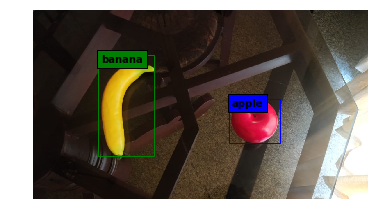

In [32]:
import matplotlib.patches as patches

classes = [class_names[out_class] for out_class in out_classes]
color = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(1)
ax.set_axis_off()
img = plt.imread('input/example.jpeg')
for i in range(len(out_classes)):
    s = (out_boxes[i][1], out_boxes[i][0])
    e = (out_boxes[i][3], out_boxes[i][2])
    rect = patches.Rectangle(s, abs(s[0] - e[0]), abs(s[1] - e[1]), edgecolor = color[i % len(color)], facecolor = 'none')
    plt.text(s[0] + 10, s[1] + 25, classes[i], fontsize = 10, weight = 'heavy', color = 'black', bbox=dict(facecolor = color[i % len(color)], alpha = 1))
    ax.imshow(img)
    ax.add_patch(rect)
plt.show()
fig.savefig('output/example.png')

In [ ]:
# Video capture
import cv2

cap = cv2.VideoCapture('demo_input.avi')

count = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break
        
    cv2.imshow('frame', frame)
    cv2.imwrite('video/' + '0' * (4 - len(str(count))) + str(count) + '.jpg', frame)
    count += 1
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
image_files = os.listdir('video')

for image_file in image_files:
    image, image_data = preprocess_image("video/" + image_file, model_image_size = (608, 608))

    out_scores, out_boxes, out_classes = sess.run([scores, boxes, classes],feed_dict={yolo_model.input:image_data,K.learning_phase(): 0})

    print('Found {} boxes for {}'.format(len(out_boxes), image_file))
    colors = generate_colors(class_names)
    print(out_scores, out_boxes, out_classes)
    draw_boxes(image, out_scores, out_boxes, out_classes, class_names, colors)
    image.save(os.path.join("video_out", image_file), quality=90)
    
    # img = cv2.imread('video_out/' + image_file)
    # cv2.imshow('aa', img)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()

In [ ]:
img_array = []
for image_file in os.listdir('video_out'):
    img = cv2.imread('video_out/' + image_file)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)
    
out = cv2.VideoWriter('demo_output.avi',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

In [ ]:
import cv2
import matplotlib.pyplot as plt

cap = cv2.VideoCapture(0)
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('demo_input.avi', fourcc, 20.0 , (640, 480))
while True:
    ret, frame = cap.read()
    cv2.imshow('frame',frame)
    out.write(frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
out.release()
cv2.destroyAllWindows()